In [1]:
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def gridsearch_timeseriessplit(dataframe, is_logarithmic=False, with_seasonality=False, test_size=1):
    tss = TimeSeriesSplit(n_splits=10, test_size=test_size, gap=0)
    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    
    if is_logarithmic:
        column = "logclose"
    else:
        column = "eth_close"

    for train_idx, val_idx in tss.split(dataframe):
        train = dataframe.iloc[train_idx]
        test = dataframe.iloc[val_idx]
        print(train_idx)
        
        if with_seasonality:
            model = pm.auto_arima(train[column],
                                  error_action="ignore",
                                  maxiter=10,
                                  suppress_warnings=True,
                                  max_p=12,
                                  max_q=2, 
                                  max_order=14,
                                  seasonal=True,
                                  stepwise=True,
                                  n_jobs=-1,
                                  m=14)
        else:
            model = pm.auto_arima(train[column],
                      error_action="ignore",
                      suppress_warnings=True,
                      maxiter=10,
                      seasonal=False,
                      n_jobs=-1)
                    
        train_pred = model.predict_in_sample(start=1, end=-1) ## plottolásnál fontos
        fcast, confint = model.predict(n_periods=len(test), return_conf_int=True) ## confint plottolásnál fontos
        
        if is_logarithmic:
            rmse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=False)
            root_mean_squared_errors.append(rmse)
            mse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=True)
            mean_squared_errors.append(mse)        
            mae = mean_absolute_error(test['eth_close'], np.exp(fcast))
            mean_absolute_errors.append(mae)
            mape = mean_absolute_percentage_error(test['eth_close'], np.exp(fcast))
            mean_absolute_percentage_errors.append(mape)
        else:
            rmse = mean_squared_error(test['eth_close'], fcast, squared=False)
            root_mean_squared_errors.append(rmse)
            mse = mean_squared_error(test['eth_close'], fcast, squared=True)
            mean_squared_errors.append(mse)        
            mae = mean_absolute_error(test['eth_close'], fcast)
            mean_absolute_errors.append(mae)
            mape = mean_absolute_percentage_error(test['eth_close'], fcast)
            mean_absolute_percentage_errors.append(mape)


    #plt.show()
    print(model.summary())
    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return train_pred, test[column], fcast, confint

In [3]:
df = pd.read_csv('training_dataset.csv', index_col='date', parse_dates=True)

In [4]:
df.index.freq = "D"

In [5]:
df.head()

,eth_low,eth_high,eth_open,eth_close,eth_volume,month,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,...,stochastic_oscillator,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,2017-09-01,1.635228e+06,4124.0,1564.05531,6.096309e+05,...,96.424850,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2017-09-01,2.904008e+06,8217.0,2460.66776,8.684873e+05,...,97.629707,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,2017-09-01,1.801703e+06,6153.0,2240.91753,7.679383e+05,...,79.514749,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2017-09-01,2.002446e+06,7403.0,2954.16805,8.770111e+05,...,78.967144,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2017-09-01,2.397491e+06,8999.0,4312.97282,1.251959e+06,...,55.783836,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008


In [6]:
df.shape

(2014, 46)

In [7]:
df.isna().sum()

eth_low                     0
eth_high                    0
eth_open                    0
eth_close                   0
eth_volume                  0
month                       0
eth_qav                     0
eth_num_trades              0
eth_taker_base_vol          0
eth_taker_quote_vol         0
btc_close                   0
btc_volume                  0
btc_num_trades              0
btc_qav                     0
fed_eff_funds_rate_close    0
nasdaq_close                0
real_estate_index_close     0
sp500_close                 0
silver_value                0
us_breake_inf_rate_5y       0
us_breake_inf_rate_10y      0
us_treasury_10yt2y_diff     0
us_treasury_10yt3m_diff     0
us_treasury_total_vol       0
gold_value                  0
news_sentiment              0
ethereum_search_trend       0
reddit_sentiment            0
twitter_sentiment           0
unique_whales               0
whales_tx_number            0
whales_tx_total_value       0
macd                        0
signal    

In [8]:
df.dropna(axis=0, how="any",inplace=True) ##ezt még átgondolni

In [9]:
df.drop("month", axis=1, inplace=True)

In [10]:
df["log_close"] = np.log(df["eth_close"])

In [11]:
df.head()

,eth_low,eth_high,eth_open,eth_close,eth_volume,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,btc_close,...,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band,log_close
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,1.635228e+06,4124.0,1564.05531,6.096309e+05,4834.91,...,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059,5.962190
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2.904008e+06,8217.0,2460.66776,8.684873e+05,4472.14,...,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483,5.838139
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,1.801703e+06,6153.0,2240.91753,7.679383e+05,4509.08,...,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813,5.834138
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2.002446e+06,7403.0,2954.16805,8.770111e+05,4100.11,...,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971,5.648164
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2.397491e+06,8999.0,4312.97282,1.251959e+06,4366.47,...,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008,5.743292


In [12]:
df_close = df[["eth_close"]]

In [13]:
df_close["logclose"] = np.log(df_close.eth_close)

C:\Users\Dani\AppData\Local\Temp\ipykernel_33428\3991135337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close["logclose"] = np.log(df_close.eth_close)


In [14]:
df_close.head()

,eth_close,logclose
date,,
2017-09-01,388.46,5.962190
2017-09-02,343.14,5.838139
2017-09-03,341.77,5.834138
2017-09-04,283.77,5.648164
2017-09-05,312.09,5.743292


In [15]:
df_close = df_close.sort_index()

## Auto Arima on training dataset - Without exogenous features

### Without seasonality, Normal Values

## 1 DAY

In [16]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=False, test_size=1)

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2001 2002 2003]
[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2003 2004 2005]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2006 2007 2008]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2007 2008 2009]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2009 2010 2011]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2010 2011 2012]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2013
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -11609.272
Date:                Tue, 18 Apr 2023   AIC                          23222.544
Time:                        15:42:30   BIC                          23233.757
Sample:                    09-01-2017   HQIC                         23226.660
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0789      0.012     -6.838      0.000      -0.101      -0.056
sigma2      6017.8250     60.947     98.738      0.000    5898.370    6137.280
Ljung-Box (L1) (Q):                   0.00   Jarque-

## 3 DAY

In [17]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=False, test_size=3)

[   0    1    2 ... 1981 1982 1983]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1984 1985 1986]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1987 1988 1989]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1993 1994 1995]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1996 1997 1998]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1999 2000 2001]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2011
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -11598.731
Date:                Tue, 18 Apr 2023   AIC                          23201.461
Time:                        15:42:46   BIC                          23212.673
Sample:                    09-01-2017   HQIC                         23205.577
                         - 03-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0789      0.012     -6.831      0.000      -0.101      -0.056
sigma2      6023.8125     61.070     98.637      0.000    5904.117    6143.508
Ljung-Box (L1) (Q):                   0.00   Jarque-

## 7 DAY

In [18]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=False, test_size=7)

[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1948 1949 1950]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1962 1963 1964]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1976 1977 1978]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2007
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -11576.823
Date:                Tue, 18 Apr 2023   AIC                          23157.645
Time:                        15:43:02   BIC                          23168.853
Sample:                    09-01-2017   HQIC                         23161.760
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0788      0.012     -6.821      0.000      -0.101      -0.056
sigma2      6030.8724     61.215     98.519      0.000    5910.892    6150.852
Ljung-Box (L1) (Q):                   0.00   Jarque-

## 14 DAY

In [19]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=False, test_size=14)

[   0    1    2 ... 1871 1872 1873]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1885 1886 1887]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1899 1900 1901]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1913 1914 1915]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1927 1928 1929]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -11539.470
Date:                Tue, 18 Apr 2023   AIC                          23082.940
Time:                        15:43:18   BIC                          23094.140
Sample:                    09-01-2017   HQIC                         23087.052
                         - 02-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0789      0.012     -6.804      0.000      -0.102      -0.056
sigma2      6049.2827     61.594     98.213      0.000    5928.561    6170.004
Ljung-Box (L1) (Q):                   0.00   Jarque-

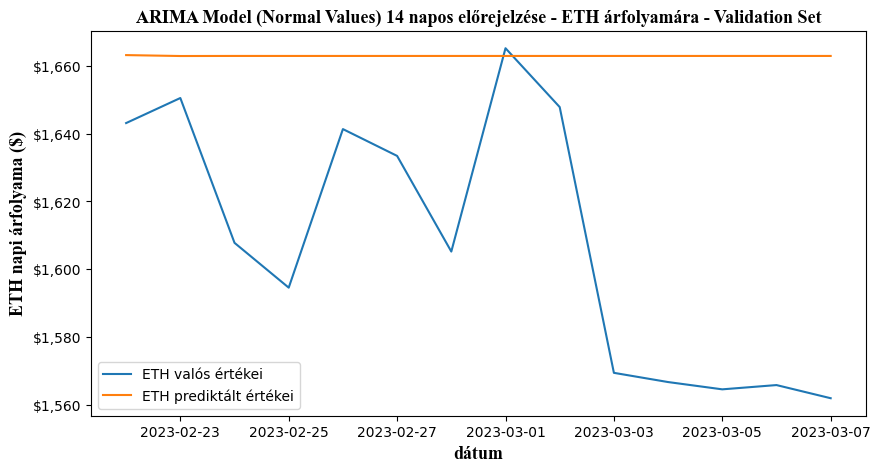

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(true_values, label="ETH valós értékei")
ax.plot(fcast, label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)

#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("ARIMA Model (Normal Values) 14 napos előrejelzése - ETH árfolyamára - Validation Set", **font)
plt.savefig("charts/forecast/arima_noseasonality_normalval_example.png")
plt.show()

### Findings: Linear trend, not so good,

### Without seasonality, Log Values

## 1 DAY

In [21]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=False, test_size=1)

[   0    1    2 ... 2001 2002 2003]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2003 2004 2005]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2006 2007 2008]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2007 2008 2009]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2009 2010 2011]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2010 2011 2012]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2013
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3088.204
Date:                Tue, 18 Apr 2023   AIC                          -6170.407
Time:                        15:44:02   BIC                          -6153.587
Sample:                    09-01-2017   HQIC                         -6164.233
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0641      0.015     -4.189      0.000      -0.094      -0.034
ar.L2          0.0547      0.020      2.676      0.007       0.015       0.095
sigma2         0.0027   3.41e-05     79.768      0.0

## 3 DAY

In [22]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=False, test_size=3)

[   0    1    2 ... 1981 1982 1983]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1984 1985 1986]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1987 1988 1989]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1993 1994 1995]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1996 1997 1998]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1999 2000 2001]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2011
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3084.135
Date:                Tue, 18 Apr 2023   AIC                          -6162.269
Time:                        15:44:45   BIC                          -6145.452
Sample:                    09-01-2017   HQIC                         -6156.096
                         - 03-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0641      0.015     -4.185      0.000      -0.094      -0.034
ar.L2          0.0547      0.020      2.674      0.007       0.015       0.095
sigma2         0.0027   3.41e-05     79.686      0.0

## 7 DAY

In [23]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=False, test_size=7)

[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1948 1949 1950]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1962 1963 1964]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1976 1977 1978]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2007
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3076.733
Date:                Tue, 18 Apr 2023   AIC                          -6147.466
Time:                        15:45:29   BIC                          -6130.654
Sample:                    09-01-2017   HQIC                         -6141.294
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.015     -4.176      0.000      -0.094      -0.034
ar.L2          0.0550      0.020      2.687      0.007       0.015       0.095
sigma2         0.0027   3.42e-05     79.582      0.0

## 14 DAY

In [24]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=False, test_size=14)

[   0    1    2 ... 1871 1872 1873]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1885 1886 1887]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1899 1900 1901]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1913 1914 1915]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1927 1928 1929]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3062.905
Date:                Tue, 18 Apr 2023   AIC                          -6119.811
Time:                        15:46:11   BIC                          -6103.010
Sample:                    09-01-2017   HQIC                         -6113.642
                         - 02-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.015     -4.165      0.000      -0.094      -0.034
ar.L2          0.0553      0.021      2.690      0.007       0.015       0.096
sigma2         0.0027   3.44e-05     79.328      0.0

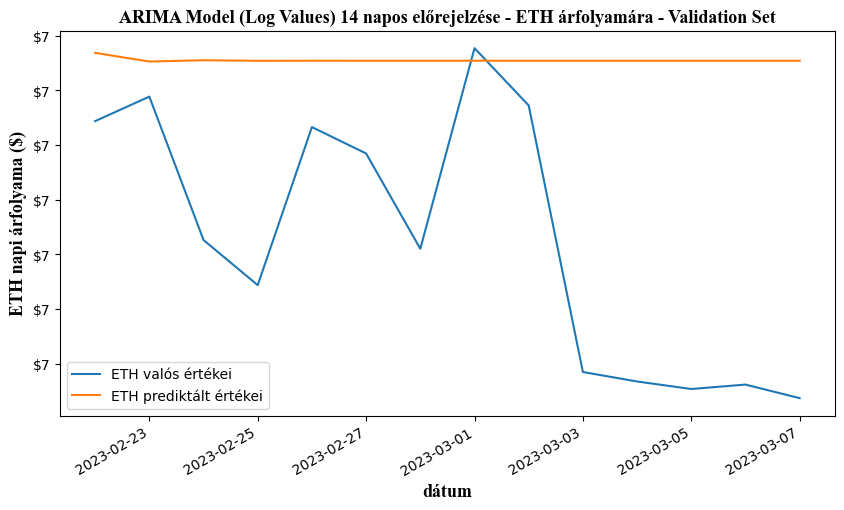

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(true_values, label="ETH valós értékei")
ax.plot(fcast, label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("ARIMA Model (Log Values) 14 napos előrejelzése - ETH árfolyamára - Validation Set", **font)
plt.savefig("charts/forecast/arima_noseasonality_logval_example.png")
plt.show()

### With seasonality, Normal Values

## 1 DAY

In [26]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=True, test_size=1)

[   0    1    2 ... 2001 2002 2003]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2003 2004 2005]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]
[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2006 2007 2008]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2007 2008 2009]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2009 2010 2011]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2010 2011 2012]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2013
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 14)   Log Likelihood              -11604.556
Date:                              Tue, 18 Apr 2023   AIC                          23217.112
Time:                                      15:51:45   BIC                          23239.539
Sample:                                  09-01-2017   HQIC                         23225.344
                                       - 03-06-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0780      0.012     -6.764      0.000      -0.101      -0.055
ar.S.L14      -0.75

## 3 DAY

In [27]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=True, test_size=3)

[   0    1    2 ... 1981 1982 1983]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1984 1985 1986]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1987 1988 1989]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1993 1994 1995]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1996 1997 1998]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1999 2000 2001]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2011
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 14)   Log Likelihood              -11594.018
Date:                              Tue, 18 Apr 2023   AIC                          23196.036
Time:                                      15:57:21   BIC                          23218.459
Sample:                                  09-01-2017   HQIC                         23204.267
                                       - 03-04-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0780      0.012     -6.758      0.000      -0.101      -0.055
ar.S.L14      -0.75

## 7 DAY

In [28]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=True, test_size=7)

[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1948 1949 1950]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1962 1963 1964]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1976 1977 1978]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2007
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 14)   Log Likelihood              -11572.138
Date:                              Tue, 18 Apr 2023   AIC                          23152.276
Time:                                      16:02:46   BIC                          23174.691
Sample:                                  09-01-2017   HQIC                         23160.505
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0779      0.012     -6.740      0.000      -0.100      -0.055
ar.S.L14      -0.75

## 14 DAY

In [29]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=False, with_seasonality=True, test_size=14)

[   0    1    2 ... 1871 1872 1873]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1885 1886 1887]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1899 1900 1901]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1913 1914 1915]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1927 1928 1929]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2000
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 14)   Log Likelihood              -11534.838
Date:                              Tue, 18 Apr 2023   AIC                          23077.677
Time:                                      16:07:51   BIC                          23100.078
Sample:                                  09-01-2017   HQIC                         23085.902
                                       - 02-21-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0779      0.012     -6.723      0.000      -0.101      -0.055
ar.S.L14      -0.75

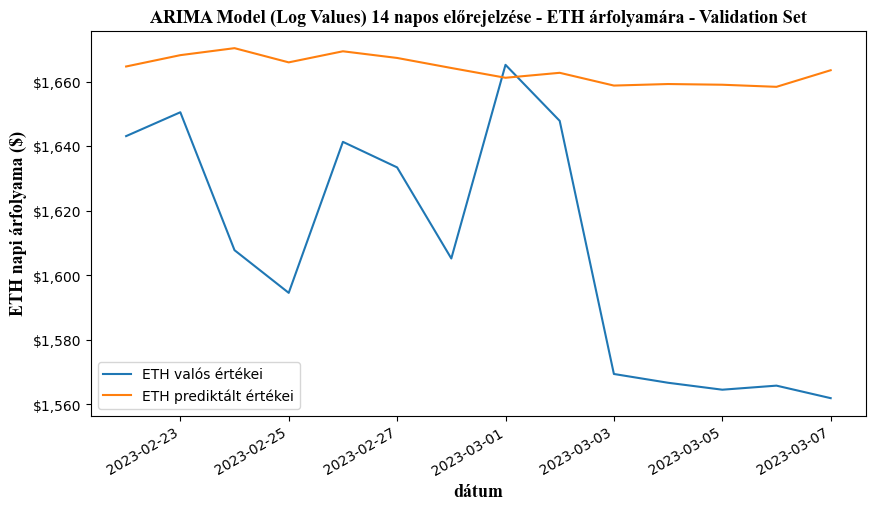

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(true_values, label="ETH valós értékei")
ax.plot(fcast, label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("ARIMA Model (Log Values) 14 napos előrejelzése - ETH árfolyamára - Validation Set", **font)
plt.savefig("charts/forecast/arima_seasonality_normalval_example.png")
plt.show()

### With seasonality, Log Values

## 1 DAY

In [31]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=True, test_size=1)

[   0    1    2 ... 2001 2002 2003]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2003 2004 2005]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2006 2007 2008]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2007 2008 2009]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2009 2010 2011]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2010 2011 2012]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2013
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3088.204
Date:                Tue, 18 Apr 2023   AIC                          -6170.407
Time:                        16:10:21   BIC                          -6153.587
Sample:                    09-01-2017   HQIC                         -6164.233
                         - 03-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0641      0.015     -4.189      0.000      -0.094      -0.034
ar.L2          0.0547      0.020      2.676      0.007       0.015       0.095
sigma2         0.0027   3.41e-05     79.768      0.0

## 3 DAY

In [32]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=True, test_size=3)

[   0    1    2 ... 1981 1982 1983]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1984 1985 1986]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1987 1988 1989]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1993 1994 1995]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1996 1997 1998]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1999 2000 2001]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2002 2003 2004]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2005 2006 2007]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2008 2009 2010]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2011
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3084.135
Date:                Tue, 18 Apr 2023   AIC                          -6162.269
Time:                        16:12:48   BIC                          -6145.452
Sample:                    09-01-2017   HQIC                         -6156.096
                         - 03-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0641      0.015     -4.185      0.000      -0.094      -0.034
ar.L2          0.0547      0.020      2.674      0.007       0.015       0.095
sigma2         0.0027   3.41e-05     79.686      0.0

## 7 DAY

In [33]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=True, test_size=7)

[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1948 1949 1950]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1962 1963 1964]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1976 1977 1978]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1990 1991 1992]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 2004 2005 2006]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2007
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3076.733
Date:                Tue, 18 Apr 2023   AIC                          -6147.466
Time:                        16:15:25   BIC                          -6130.654
Sample:                    09-01-2017   HQIC                         -6141.294
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.015     -4.176      0.000      -0.094      -0.034
ar.L2          0.0550      0.020      2.687      0.007       0.015       0.095
sigma2         0.0027   3.42e-05     79.582      0.0

## 14 DAY

In [34]:
train_pred, true_values, fcast, confint = gridsearch_timeseriessplit(df_close, is_logarithmic=True, with_seasonality=True, test_size=14)

[   0    1    2 ... 1871 1872 1873]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1885 1886 1887]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1899 1900 1901]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1913 1914 1915]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1927 1928 1929]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1941 1942 1943]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1955 1956 1957]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1969 1970 1971]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1983 1984 1985]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


[   0    1    2 ... 1997 1998 1999]


C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:               SARIMAX(2, 1, 0)   Log Likelihood                3062.905
Date:                Tue, 18 Apr 2023   AIC                          -6119.811
Time:                        16:17:53   BIC                          -6103.010
Sample:                    09-01-2017   HQIC                         -6113.642
                         - 02-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0640      0.015     -4.165      0.000      -0.094      -0.034
ar.L2          0.0553      0.021      2.690      0.007       0.015       0.096
sigma2         0.0027   3.44e-05     79.328      0.0

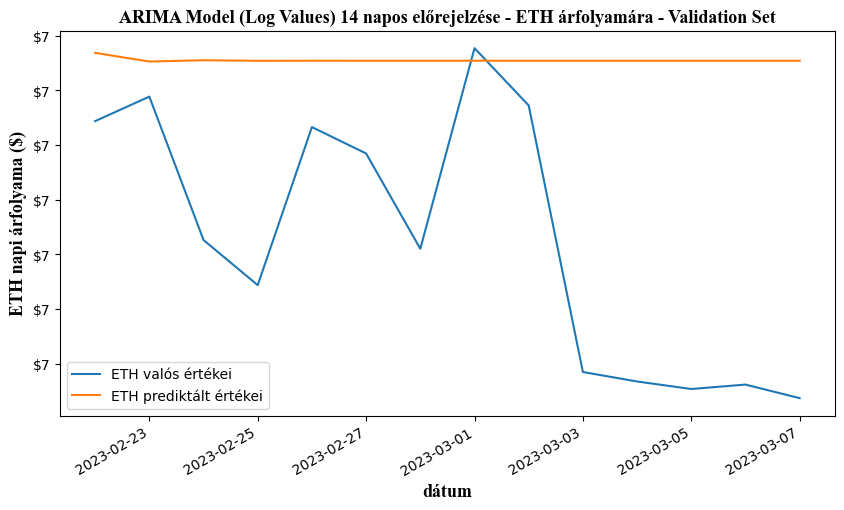

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(true_values, label="ETH valós értékei")
ax.plot(fcast, label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("ARIMA Model (Log Values) 14 napos előrejelzése - ETH árfolyamára - Validation Set", **font)
plt.savefig("charts/forecast/arima_seasonality_normalval_example.png")
plt.show()

## Test on Real-World dataset

## 1 day real world prediction

In [36]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [37]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [38]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=0)] ## 1 day

In [39]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [40]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [41]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [42]:
eth_current_price.head()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692


In [43]:
train = df_close.copy()

In [44]:
model = pm.auto_arima(train["eth_close"],
          error_action="ignore",
          suppress_warnings=True,
          maxiter=10,
          seasonal=False,
          n_jobs=-1)

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [45]:
eth_current_price["prediction"] = model.predict(n_periods=len(eth_current_price))

In [46]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

28.177693699149813

In [47]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

793.982422203107

In [48]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

28.177693699149813

In [49]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.018367713574228388

## 3 day real world prediction

In [50]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [51]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [52]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=2)] ## 3 day

In [53]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [54]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [55]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [56]:
eth_current_price.head()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841


In [57]:
train = df_close.copy()

In [58]:
model = pm.auto_arima(train["eth_close"],
          error_action="ignore",
          suppress_warnings=True,
          maxiter=10,
          seasonal=False,
          n_jobs=-1)

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [59]:
eth_current_price["prediction"] = model.predict(n_periods=len(eth_current_price))

In [60]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

106.11008410258124

In [61]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

11259.349948256864

In [62]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

94.94813302861728

In [63]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.06579649796844676

## 7 day real world prediction

In [64]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')
eth_current_price = pd.DataFrame(tickerDf)


In [65]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [66]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=6)] ## 1 day

In [67]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [68]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [69]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [70]:
eth_current_price.head()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674


In [71]:
train = df_close.copy()

In [72]:
model = pm.auto_arima(train["eth_close"],
          error_action="ignore",
          suppress_warnings=True,
          maxiter=10,
          seasonal=False,
          n_jobs=-1)

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [73]:
eth_current_price["prediction"] = model.predict(n_periods=len(eth_current_price))

In [74]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

103.37177234281452

In [75]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

10685.723317294674

In [76]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

93.12135994047743

In [77]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.06027479065933179

## 14 day real world prediction

In [78]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [79]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [80]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=13)] ## 1 day

In [81]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [82]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [83]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [84]:
eth_current_price.head()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674


In [85]:
train = df_close.copy()

In [86]:
model = pm.auto_arima(train["eth_close"],
          error_action="ignore",
          suppress_warnings=True,
          maxiter=10,
          seasonal=False,
          n_jobs=-1)

C:\Users\Dani\AppData\Local\Programs\Python\Python310\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [87]:
eth_current_price["prediction"] = model.predict(n_periods=len(eth_current_price))

In [88]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

153.35365498830097

In [89]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

23517.343498270846

In [90]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

137.95312427350603

In [91]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.08207047583650873

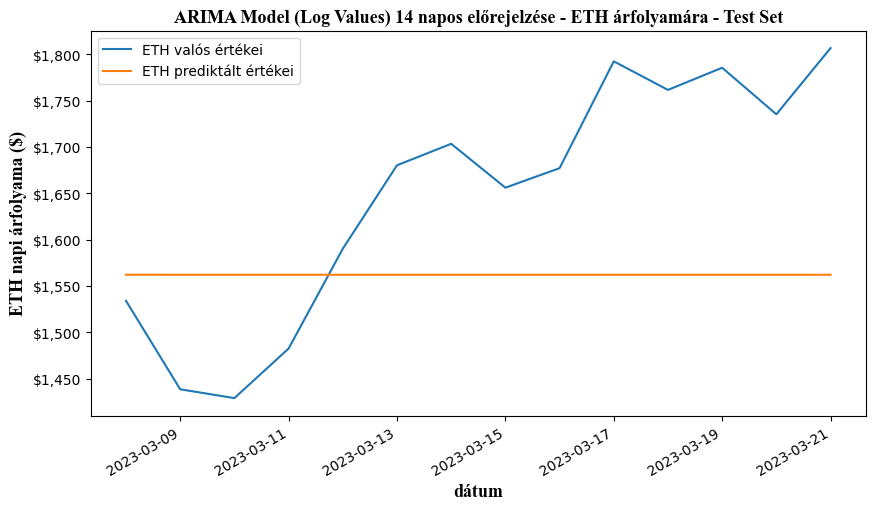

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(eth_current_price['eth_close'], label="ETH valós értékei")
ax.plot( eth_current_price["prediction"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("ARIMA Model (Log Values) 14 napos előrejelzése - ETH árfolyamára - Test Set", **font)
plt.savefig("charts/forecast/arima_realworld_example.png")
plt.show()

## With exogeneous features (but it can't be applied on crypto era)

In [93]:
test_size = 400 ## 20% of total dataset
train = df.iloc[:-test_size]["log_close"]
test = df.iloc[-test_size:]["log_close"]

In [94]:
model = pm.auto_arima(y=train.eth_close, X=train.drop(["eth_close"], axis=1),
                      error_action="ignore",
                      trace=True,
                      suppress_warnings=True,
                      maxiter=10,
                      seasonal=False)

AttributeError: 'Series' object has no attribute 'eth_close'

In [ ]:
model.summary()

In [ ]:
test.head()

In [ ]:
def plot_test(model, test):
    test_pred = model.predict(X = test.drop("eth_close", axis=1), n_periods=test_size)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test.eth_close, label='true')
    ax.plot(test.index, test_pred.values, label='forecast')
    ax.legend();

In [ ]:
plot_test(model, test)

In [ ]:
def rmse(y, t):
    return np.sqrt(np.mean((t - y)**2))

In [ ]:
print("RMSE ARIMA:", rmse(model.predict(X = test.drop("eth_close", axis=1), n_periods=test_size), test.eth_close))